In [9]:
import transformers

model = transformers.AutoModel.from_pretrained("jxm/cde-small-v1", trust_remote_code=True)
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")

C:\Users\giuli\.cache\huggingface\modules\transformers_modules\nomic-ai\nomic-bert-2048\eb02ceb48c1fdcc477ff1925c9732c379f0f0d1f\modeling_hf_nomic_bert.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

Disabled 37 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.BiEncoder'>
modified 12 rotary modules – set rotary_start_pos to 512
Disabled 74 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.DatasetTransformer'>


In [ ]:
from datasets import Features, Value, Sequence, load_dataset

# Carica il dataset da un file JSON locale
corpus = load_dataset("json", data_files="hotpotqa/hotpotqa/corpus.jsonl")
# Droppa 'metadata' dal dataset, contiene solo url e del documento
corpus = corpus.remove_columns(['metadata']) 

print(corpus)
print(corpus['train'][:5])  # Mostra le prime 5 righe del corpus

DatasetDict({
    train: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 5233329
    })
})
{'_id': ['12', '25', '39', '290', '303'], 'title': ['Anarchism', 'Autism', 'Albedo', 'A', 'Alabama'], 'text': ['Anarchism is a political philosophy that advocates self-governed societies based on voluntary institutions. These are often described as stateless societies, although several authors have defined them more specifically as institutions based on non-hierarchical free associations. Anarchism holds the state to be undesirable, unnecessary and harmful.', "Autism is a neurodevelopmental disorder characterized by impaired social interaction, impaired verbal and non-verbal communication, and restricted and repetitive behavior. Parents usually notice signs in the first two years of their child's life. These signs often develop gradually, though some children with autism reach their developmental milestones at a normal pace and then regress. The diagnostic criteria require

In [5]:
import json

# Paths to the input and output files
input_file = "hotpotqa/hotpotqa/queries.jsonl"
output_file = "hotpotqa/hotpotqa/queries_fixed.jsonl"

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    for line in infile:
        data = json.loads(line)
        # Remove `supporting_facts` from metadata
        if "supporting_facts" in data["metadata"]:
            del data["metadata"]["supporting_facts"]
        # Write the modified data back to a new file
        outfile.write(json.dumps(data) + "\n")


In [ ]:
# Define the schema without `supporting_facts`
features = Features({
    "_id": Value("string"),
    "text": Value("string"),
    "metadata": {
        "answer": Value("string"),
    }
})

# Load the preprocessed dataset
queries = load_dataset("json", data_files="hotpotqa/hotpotqa/queries_fixed.jsonl", features=features)

print(queries)
print(queries['train'][:5])  # Display the first 5 rows


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['_id', 'text', 'metadata'],
        num_rows: 97852
    })
})
{'_id': ['5ab6d31155429954757d3384', '5ac0d92f554299012d1db645', '5abd01335542993a06baf9fc', '5abff8c95542994516f4555c', '5adec8ad55429975fa854f8f'], 'text': ['What country of origin does House of Cosbys and Bill Cosby have in common?', 'How many fountains where present "World of Color" which includes lights,fire,laser and fog which has anthology television series and created by Steve Davison, who is Lead Creative Executive of Parades for Walt Disney and author such a shows as "Believe..There\'s Magic in the Start", "Disney Dreams!"?', 'Chris Larceny directed the music video Gon Jock, featuring a Haitian rapper who first achieved fame as a member of what New Jersey hip hop group?', 'The person where local tradition says Cross Lake is the boyhood home of co-founded what group?', 'The actor who played Carl Sweetchuck in the "Police Academy" films wrote the screenplay for "A

In [11]:
query_prefix = "search_query: "
document_prefix = "search_document: "

import random

def process_ex_document(ex: dict) -> dict:
  ex["text"] = f"{ex['title']} {ex['text']}"
  return ex

corpus_size = model.config.transductive_corpus_size
minicorpus_docs = corpus['train'].select(random.choices(list(range(len(corpus['train']))), k=corpus_size))
minicorpus_docs = minicorpus_docs.map(process_ex_document)["text"]
minicorpus_docs = tokenizer(
    [document_prefix + doc for doc in minicorpus_docs],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

Map:   0%|          | 0/512 [00:00<?, ? examples/s]

# 1. gather embeddings

In [12]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model.to(device)
minicorpus_docs = minicorpus_docs.to(device)

Using cuda


In [13]:
import torch
from tqdm.autonotebook import tqdm

batch_size = 32

dataset_embeddings = []
for i in tqdm(range(0, len(minicorpus_docs["input_ids"]), batch_size)):
    minicorpus_docs_batch = {k: v[i:i+batch_size] for k,v in minicorpus_docs.items()}
    with torch.no_grad():
        dataset_embeddings.append(
            model.first_stage_model(**minicorpus_docs_batch)
        )

dataset_embeddings = torch.cat(dataset_embeddings)

  0%|          | 0/16 [00:00<?, ?it/s]

# 2. Embed in context

In [14]:
docs = corpus['train'].select(range(16)).map(process_ex_document)["text"]

docs = tokenizer(
    [document_prefix + doc for doc in docs],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

with torch.no_grad():
  doc_embeddings = model.second_stage_model(
      input_ids=docs["input_ids"],
      attention_mask=docs["attention_mask"],
      dataset_embeddings=dataset_embeddings,
  )
doc_embeddings /= doc_embeddings.norm(p=2, dim=1, keepdim=True)

In [16]:
queries = queries["train"].select(range(16))["text"]
queries = tokenizer(
    [query_prefix + query for query in queries],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

with torch.no_grad():
  query_embeddings = model.second_stage_model(
      input_ids=queries["input_ids"],
      attention_mask=queries["attention_mask"],
      dataset_embeddings=dataset_embeddings,
  )
query_embeddings /= query_embeddings.norm(p=2, dim=1, keepdim=True)

<Axes: >

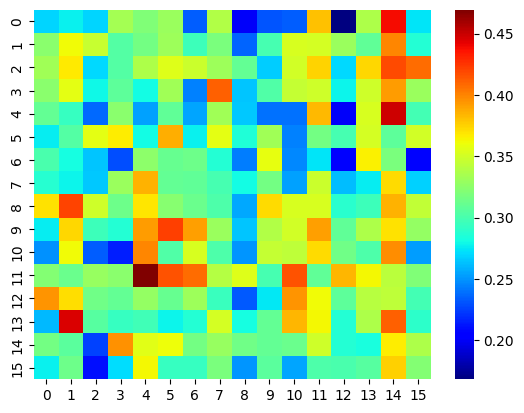

In [ ]:
import seaborn as sns

sns.heatmap((doc_embeddings @ query_embeddings.T).cpu(), cmap="jet") # the more red the better the similarity

In [23]:
# print the most similar document for each query

for i in range(len(queries["input_ids"])):
    sim = doc_embeddings @ query_embeddings[i].T
    best_doc_idx = sim.argmax()
    query_text = tokenizer.decode(queries["input_ids"][i], skip_special_tokens=True)
    best_doc_text = tokenizer.decode(docs["input_ids"][best_doc_idx], skip_special_tokens=True)
    print(f"Query: {query_text}")
    print(f"Best document: {best_doc_text}")
    print(f"Similarity: {sim[best_doc_idx].item()}")
    print()

Query: search _ query : what country of origin does house of cosbys and bill cosby have in common?
Best document: search _ document : animalia ( book ) animalia is an illustrated children ' s book by graeme base. it was originally published in 1986, followed by a tenth anniversary edition in 1996, and a 25th anniversary edition in 2012. over three million copies have been sold. a special numbered and signed anniversary edition was also published in 1996, with an embossed gold jacket.
Similarity: 0.3952404856681824

Query: search _ query : how many fountains where present " world of color " which includes lights, fire, laser and fog which has anthology television series and created by steve davison, who is lead creative executive of parades for walt disney and author such a shows as " believe.. there ' s magic in the start ", " disney dreams! "?
Best document: search _ document : international atomic time international atomic time ( tai, from the french name " temps atomique internation

In [32]:
# Define synthetic documents and a query
synthetic_docs = [
    {"title": "Document 1", "text": "This is the first synthetic document about machine learning."},
    {"title": "Document 2", "text": "This document discusses the applications of artificial intelligence."},
    {"title": "Document 3", "text": "Here we talk about the advancements in natural language processing."},
    {"title": "Document 4", "text": "This document is about the history of computer science."},
    {"title": "Document 5", "text": "pizza is delicious"},
]

synthetic_query = "What are the applications of artificial intelligence?"

# Process synthetic documents
synthetic_docs = [process_ex_document(doc) for doc in synthetic_docs]
synthetic_docs_texts = [doc["text"] for doc in synthetic_docs]
synthetic_docs_tokenized = tokenizer(
    [document_prefix + doc for doc in synthetic_docs_texts],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

# Generate embeddings for synthetic documents
with torch.no_grad():
    synthetic_doc_embeddings = model.second_stage_model(
        input_ids=synthetic_docs_tokenized["input_ids"],
        attention_mask=synthetic_docs_tokenized["attention_mask"],
        dataset_embeddings=dataset_embeddings,
    )
synthetic_doc_embeddings /= synthetic_doc_embeddings.norm(p=2, dim=1, keepdim=True)

# Tokenize and embed the synthetic query
synthetic_query_tokenized = tokenizer(
    query_prefix + synthetic_query,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

with torch.no_grad():
    synthetic_query_embedding = model.second_stage_model(
        input_ids=synthetic_query_tokenized["input_ids"],
        attention_mask=synthetic_query_tokenized["attention_mask"],
        dataset_embeddings=dataset_embeddings,
    )
synthetic_query_embedding /= synthetic_query_embedding.norm(p=2, dim=1, keepdim=True)

# Calculate similarity
similarity_scores = (synthetic_doc_embeddings @ synthetic_query_embedding.T).cpu().numpy().flatten()

# Print similarity list ordered
print("Query:", synthetic_query)
print("Similarity scores with synthetic documents (ordered):")
sorted_indices = similarity_scores.argsort()[::-1]
for idx in sorted_indices:
    print(f"Document {idx+1}: {similarity_scores[idx]:.4f} - {synthetic_docs[idx]['text']}")

Query: What are the applications of artificial intelligence?
Similarity scores with synthetic documents (ordered):
Document 2: 0.7503 - Document 2 This document discusses the applications of artificial intelligence.
Document 1: 0.5347 - Document 1 This is the first synthetic document about machine learning.
Document 3: 0.4966 - Document 3 Here we talk about the advancements in natural language processing.
Document 4: 0.4690 - Document 4 This document is about the history of computer science.
Document 5: 0.3856 - Document 5 pizza is delicious
